In [162]:
import pandas as pd
import numpy as np
from datetime import datetime
import openpyxl

# Plotting
import matplotlib.pyplot as plt
import seaborn as sns

# Q3
from scipy.stats import skew, kurtosis

In [163]:
stock_prices = pd.read_csv('stock_prices.csv')
book_to_market = pd.read_csv('book_to_market.csv')

book_to_market = book_to_market.drop(['permno', 'adate', 'qdate'], axis = 1)
book_to_market = book_to_market.rename(columns = {'bm' : 'book_to_market', 'public_date' : 'date', 'TICKER' : 'tic'})
book_to_market['date'] =  pd.to_datetime(book_to_market['date'], format='%Y-%m-%d')
book_to_market['date'] = book_to_market['date'].dt.to_period('M')

stock_prices = stock_prices.drop(['gvkey', 'iid', 'navm', 'cmth', 'cyear', 'exchg', 'conm'], axis = 1)
stock_prices = stock_prices.rename(columns = {'datadate' : 'date', 'prccm' : 'price_close', 'prchm' : 'price_high', 'prclm' : 'price_low'})
stock_prices['date'] =  pd.to_datetime(stock_prices['date'], format='%Y-%m-%d')
stock_prices['date'] = stock_prices['date'].dt.to_period('M')

df_tic = pd.merge(book_to_market, stock_prices, how = 'left', on = ['tic', 'date'])
df_tic = df_tic[['date', 'tic', 'book_to_market', 'price_close', 'price_high', 'price_low']]
df_tic = df_tic.set_index('date')

#Filter relevant stocks for Group 42
df_tickers = pd.read_excel("Tickers_T4.xlsx", usecols=["Group 42"])
tickers = df_tickers['Group 42'].tolist()

# Filter the df_tic DataFrame based on the tickers
df_tic = df_tic[df_tic['tic'].isin(tickers)]

# Drop rows with missing data
df_tic.dropna(subset=['book_to_market', 'price_close'], inplace=True)

# Convert index to datetime64 type
df_tic.index = df_tic.index.to_timestamp()

display(df_tic)
df_tic.info()


,tic,book_to_market,price_close,price_high,price_low
date,,,,,
1987-11-01,FAST,0.204,12.750,13.250,12.2500
1987-12-01,FAST,0.204,14.750,14.750,12.2500
1988-01-01,FAST,0.204,16.250,16.250,14.2500
1988-02-01,FAST,0.215,16.750,17.250,15.7500
1988-03-01,FAST,0.215,15.625,17.500,15.2500
...,...,...,...,...,...
2022-08-01,FTNT,0.014,48.690,63.160,48.3100
2022-09-01,FTNT,0.014,49.130,55.940,47.3700
2022-10-01,FTNT,0.014,57.160,57.335,45.7400


<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 15876 entries, 1987-11-01 to 2022-12-01
Data columns (total 5 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   tic             15876 non-null  object 
 1   book_to_market  15876 non-null  float64
 2   price_close     15876 non-null  float64
 3   price_high      15876 non-null  float64
 4   price_low       15876 non-null  float64
dtypes: float64(4), object(1)
memory usage: 744.2+ KB


In our analysis of stock portfolios based on the book-to-market ratio, we encountered instances of missing values, particularly in the early years of the dataset. To maintain the integrity and accuracy of our analysis, we have decided to remove the rows with missing book-to-market and price_close values which signififes that the company did not exist in that year yet in the majority of cases. This approach allows us to avoid introducing any bias or inaccuracies that might arise from using arbitrary values to fill the missing data, while still preserving the robustness of our findings.

<h2 style='color:Blue'> 1. Present annualized performance statistics for your stocks  </h2>

(average return, volatility, Sharpe ratio, skewness, kurtosis and max drawdown)

In [164]:
# Calculate the monthly returns
df_tic['monthly_returns'] = df_tic.groupby('tic')['price_close'].pct_change()

# Annualize the returns
df_tic['annual_returns'] = (1 + df_tic['monthly_returns']).pow(12) - 1

# Calculate the annualized statistics for each stock
stats = df_tic.groupby('tic')['annual_returns'].agg(
    mean_return=np.mean,
    volatility=np.std,
    skewness=lambda x: x.skew(),
    kurtosis=lambda x: x.kurt()
)

# Calculate the Sharpe ratio
risk_free_rate = 0.03  
stats['sharpe_ratio'] = (stats['mean_return'] - risk_free_rate) / stats['volatility']

# Calculate max drawdown
df_tic['cum_returns'] = (1 + df_tic['monthly_returns']).cumprod()
df_tic['cum_max'] = df_tic.groupby('tic')['cum_returns'].cummax()
df_tic['drawdown'] = df_tic['cum_returns'] / df_tic['cum_max'] - 1
stats['max_drawdown'] = df_tic.groupby('tic')['drawdown'].min()

display(stats)

,mean_return,volatility,skewness,kurtosis,sharpe_ratio,max_drawdown
tic,,,,,,
AAPL,2.297728e+00,7.169554e+00,6.303614,54.786690,0.316300,-0.895886
ABC,5.018085e-01,1.496811e+00,6.053705,60.606431,0.315209,-0.779216
ACGL,1.178885e-02,3.808532e-01,1.311179,1.751423,-0.047817,-0.047619
AIZ,6.344771e-01,3.212661e+00,12.748896,179.383051,0.188155,-0.700132
ALB,1.426862e+00,6.371059e+00,10.172180,128.192873,0.219251,-0.763909
ALL,5.475457e-01,1.759382e+00,5.683019,48.708618,0.294163,-0.825143
AMD,4.950775e+04,9.042982e+05,20.547437,436.756074,0.054747,-0.980343
AMZN,9.483440e+02,1.472053e+04,15.714893,246.971672,0.064421,-0.976048
AVY,6.218179e-01,1.709208e+00,4.192580,32.784915,0.346253,-0.723499


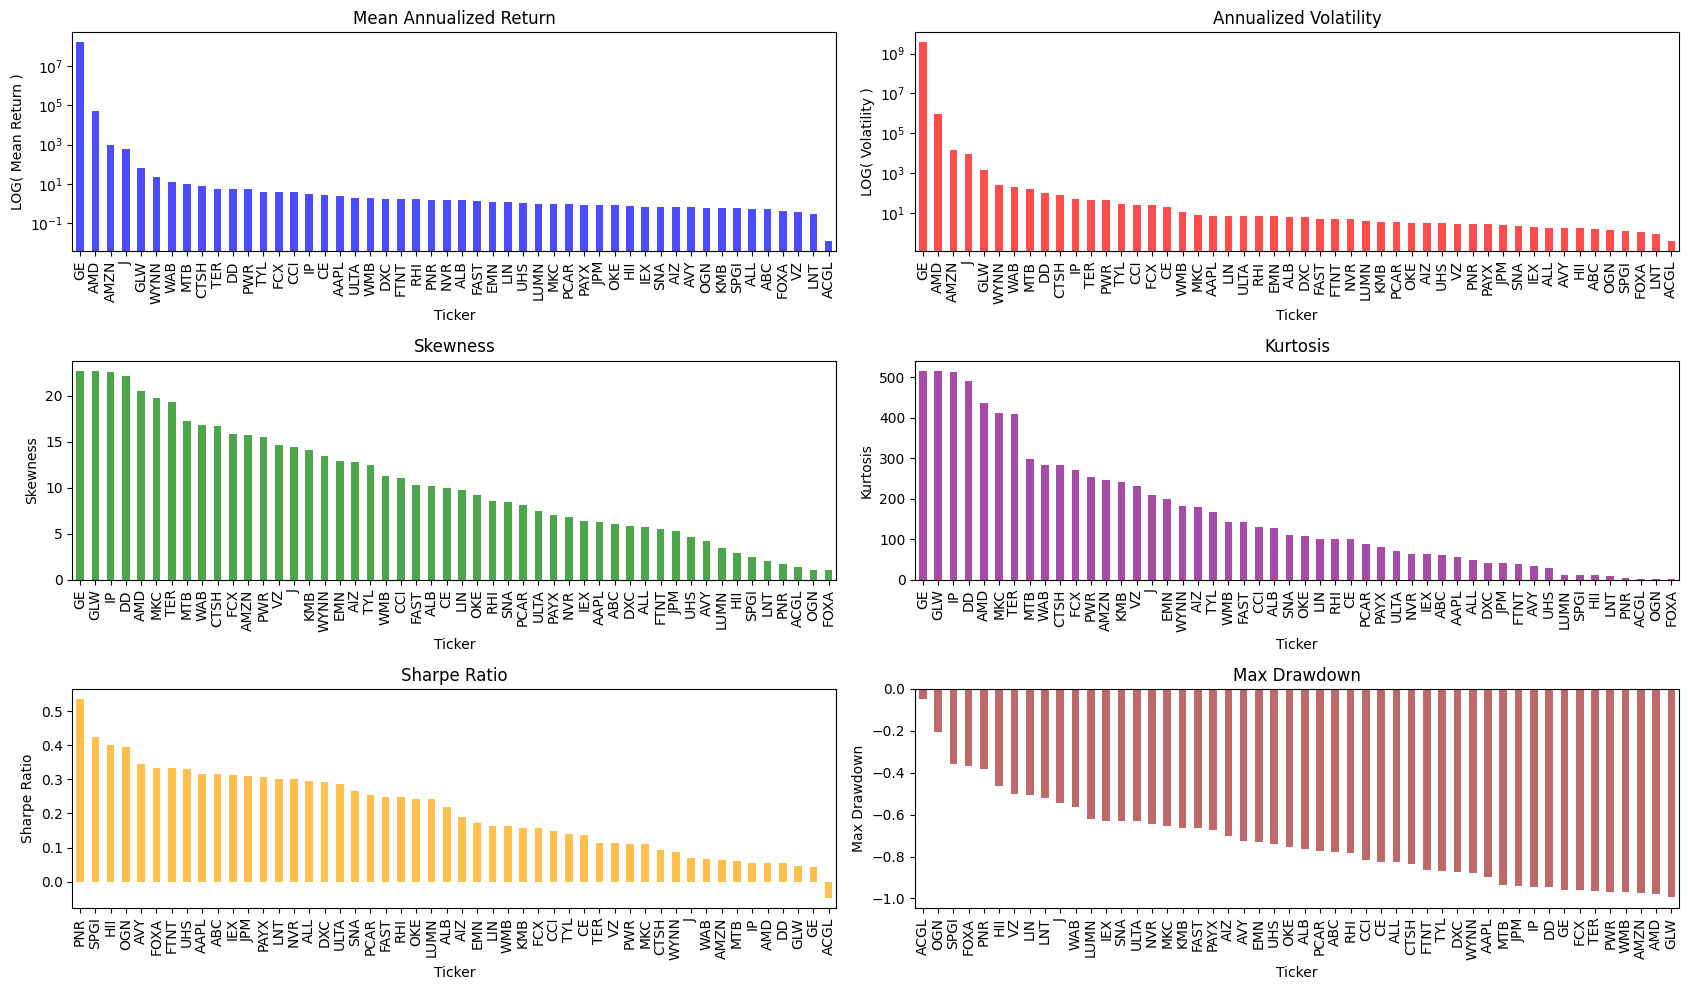

In [165]:
fig, axes = plt.subplots(3, 2, figsize=(17, 10))

def plot_stat_subplot(ax, data, title, ylabel, color, logy=False):
    data.plot(kind='bar', ax=ax, color=color, alpha=0.7, logy=logy)
    ax.set_xlabel('Ticker')
    if logy == False:
        ax.set_ylabel(ylabel)
    else:
        ax.set_ylabel('LOG( ' + ylabel + ' )')
    ax.set_title(title)

# Sort data by each statistic
stats_sorted = {
    stat: stats[stat].sort_values(ascending=False)
    for stat in ['mean_return', 'volatility', 'skewness', 'kurtosis', 'sharpe_ratio', 'max_drawdown']
}

# Mean Return
plot_stat_subplot(axes[0, 0], stats_sorted['mean_return'], 'Mean Annualized Return', 'Mean Return', 'blue', logy=True)
# Volatility
plot_stat_subplot(axes[0, 1], stats_sorted['volatility'], 'Annualized Volatility', 'Volatility', 'red', logy=True)
# Skewness
plot_stat_subplot(axes[1, 0], stats_sorted['skewness'], 'Skewness', 'Skewness', 'green')
# Kurtosis
plot_stat_subplot(axes[1, 1], stats_sorted['kurtosis'], 'Kurtosis', 'Kurtosis', 'purple')
# Sharpe Ratio
plot_stat_subplot(axes[2, 0], stats_sorted['sharpe_ratio'], 'Sharpe Ratio', 'Sharpe Ratio', 'orange')
# Max Drawdown
plot_stat_subplot(axes[2, 1], stats_sorted['max_drawdown'], 'Max Drawdown', 'Max Drawdown', 'brown')

plt.tight_layout()
plt.show()


***

<h2 style='color:Blue'> 2. Momentum indicator portfolios </h2>

Momentrum indicators are technical analysis tools used to determine the strength or weakness of a stock's price. Momentum measures the rate of the rise or fall of stock prices.

1. For each stock and each date, build a Momentum indicator which is defined as the cumulated return over the past six months.

In [166]:
# Calculate the 6-month momentum for each stock
df_tic['momentum_6m'] = df_tic.groupby('tic')['price_close'].pct_change(periods=6)
# Drop rows with missing data for 6 month momentum to avoid errors in the computation of summary sataistics
df_tic.dropna(subset='momentum_6m', inplace=True)

display(df_tic)

,tic,book_to_market,price_close,price_high,price_low,monthly_returns,annual_returns,cum_returns,cum_max,drawdown,momentum_6m
date,,,,,,,,,,,
1988-05-01,FAST,0.215,21.625,22.250,20.0000,0.054878,0.898572,1.696078e+00,1.696078e+00,0.000000,0.696078
1988-06-01,FAST,0.215,22.000,22.000,20.0000,0.017341,0.229133,1.725490e+00,1.725490e+00,0.000000,0.491525
1988-07-01,FAST,0.215,25.000,27.000,21.5000,0.136364,3.636689,1.960784e+00,1.960784e+00,0.000000,0.538462
1988-08-01,FAST,0.164,23.750,25.500,22.5000,-0.050000,-0.459640,1.862745e+00,1.960784e+00,-0.050000,0.417910
1988-09-01,FAST,0.164,19.750,20.250,15.3330,-0.168421,-0.890644,1.549020e+00,1.960784e+00,-0.210000,0.264000
...,...,...,...,...,...,...,...,...,...,...,...
2022-08-01,FTNT,0.014,48.690,63.160,48.3100,-0.183738,-0.912511,2.056478e+24,1.517967e+25,-0.864524,-0.858673
2022-09-01,FTNT,0.014,49.130,55.940,47.3700,0.009037,0.113997,2.075062e+24,1.517967e+25,-0.863300,-0.856236
2022-10-01,FTNT,0.014,57.160,57.335,45.7400,0.163444,5.150996,2.414218e+24,1.517967e+25,-0.840957,-0.802221


2. Use the characteristics Book-to-Market and Momentum to build tercile portfolios, called:
- book-to-market :  Value_high, Value_med, Value_low 
- momentum  :  MoM_high,MoM_med, MoM_low 

    To construct the six portfolios, at each date and for each one of the two characteristic, split your 50 stocks in three equally weighted groups of similar sizes (example: for momentum in Jan 2000 you may have 16 stocks in the low Momentum group, 15 in the Middle group, 15 in the high Momentum group and 4 stocks with missing observations at this date). 

In [167]:
def create_equally_weighted_groups(x, num_groups=3):
    n = len(x)
    step = n // num_groups
    indices = np.argsort(x)
    terciles = np.empty_like(indices)
    terciles[indices[:step]] = 0
    terciles[indices[step:2 * step]] = 1
    terciles[indices[2 * step:]] = 2
    return terciles

# Create tercile portfolios based on Book-to-Market and Momentum
df_tic['bm_tercile'] = df_tic.groupby('date')['book_to_market'].transform(create_equally_weighted_groups)
df_tic['mom_tercile'] = df_tic.groupby('date')['momentum_6m'].transform(create_equally_weighted_groups)

# Assign portfolio names
bm_labels = ['Value_low', 'Value_med', 'Value_high']
mom_labels = ['MoM_low', 'MoM_med', 'MoM_high']

df_tic['bm_tercile'] = df_tic['bm_tercile'].map(dict(enumerate(bm_labels)))
df_tic['mom_tercile'] = df_tic['mom_tercile'].map(dict(enumerate(mom_labels)))

display(df_tic)

,tic,book_to_market,price_close,price_high,price_low,monthly_returns,annual_returns,cum_returns,cum_max,drawdown,momentum_6m,bm_tercile,mom_tercile
date,,,,,,,,,,,,,
1988-05-01,FAST,0.215,21.625,22.250,20.0000,0.054878,0.898572,1.696078e+00,1.696078e+00,0.000000,0.696078,Value_low,MoM_high
1988-06-01,FAST,0.215,22.000,22.000,20.0000,0.017341,0.229133,1.725490e+00,1.725490e+00,0.000000,0.491525,Value_low,MoM_high
1988-07-01,FAST,0.215,25.000,27.000,21.5000,0.136364,3.636689,1.960784e+00,1.960784e+00,0.000000,0.538462,Value_low,MoM_high
1988-08-01,FAST,0.164,23.750,25.500,22.5000,-0.050000,-0.459640,1.862745e+00,1.960784e+00,-0.050000,0.417910,Value_low,MoM_high
1988-09-01,FAST,0.164,19.750,20.250,15.3330,-0.168421,-0.890644,1.549020e+00,1.960784e+00,-0.210000,0.264000,Value_low,MoM_high
...,...,...,...,...,...,...,...,...,...,...,...,...,...
2022-08-01,FTNT,0.014,48.690,63.160,48.3100,-0.183738,-0.912511,2.056478e+24,1.517967e+25,-0.864524,-0.858673,Value_low,MoM_low
2022-09-01,FTNT,0.014,49.130,55.940,47.3700,0.009037,0.113997,2.075062e+24,1.517967e+25,-0.863300,-0.856236,Value_low,MoM_low
2022-10-01,FTNT,0.014,57.160,57.335,45.7400,0.163444,5.150996,2.414218e+24,1.517967e+25,-0.840957,-0.802221,Value_low,MoM_low


3. Present annualized performance statistics for the 6 portfolios.

In [168]:
def compute_summary_statistics(df_tic, portfolio_col, portfolio_names):
    def max_drawdown(returns):
        cum_returns = (1 + returns).cumprod()
        cum_max_return = cum_returns.cummax()
        drawdown = cum_returns / cum_max_return - 1
        return drawdown.min()

    # Compute the summary statistics for each month
    monthly_stats = df_tic.groupby(['date', portfolio_col])['annual_returns'].agg(
        mean_return=lambda x: np.mean(x),
        volatility=lambda x: np.std(x),
        skewness=lambda x: x.skew(),
        kurtosis=lambda x: x.kurt(),
        max_drawdown=lambda x: max_drawdown(x)
    )

    # Annualize mean_return and volatility
    monthly_stats['annualized_mean_return'] = (1 + monthly_stats['mean_return'])**12 - 1
    monthly_stats['annualized_volatility'] = monthly_stats['volatility'] * np.sqrt(12)

    # Compute the annualized Sharpe ratio
    risk_free_rate_annual = (1 + risk_free_rate)**12 - 1
    epsilon = 1e-8
    monthly_stats['sharpe_ratio'] = (monthly_stats['annualized_mean_return'] - risk_free_rate_annual) / (monthly_stats['annualized_volatility'] + epsilon)

    # Average the statistics for each portfolio
    portfolio_stats = monthly_stats.groupby([portfolio_col]).mean()

    # Filter the desired portfolios
    portfolio_stats = portfolio_stats.reset_index()
    filtered_stats = portfolio_stats[
        (portfolio_stats[portfolio_col].isin(portfolio_names))
    ]

    # Assign the specified index labels
    filtered_stats = filtered_stats.set_index(portfolio_col)

    # Select the required columns
    selected_stats = filtered_stats[['annualized_mean_return', 'annualized_volatility', 'sharpe_ratio', 'skewness', 'kurtosis', 'max_drawdown']]

    return selected_stats

# STATS BM PORTFOLIOS
portfolio_col = 'bm_tercile'
portfolio_names = ['Value_high', 'Value_med', 'Value_low']
bm_stats = compute_summary_statistics(df_tic, portfolio_col, portfolio_names)

# STATS BM PORTFOLIOS
portfolio_col = 'mom_tercile'
portfolio_names = ['MoM_high', 'MoM_med', 'MoM_low']
mom_stats = compute_summary_statistics(df_tic, portfolio_col, portfolio_names)

stats_bm_mom = pd.concat([bm_stats, mom_stats], axis=0)
display(stats_bm_mom)


,annualized_mean_return,annualized_volatility,sharpe_ratio,skewness,kurtosis,max_drawdown
Value_high,2.518704e+44,2.854615e+02,2.303501e+39,1.481056,3.014009,-0.692652
Value_low,2.504034e+71,4.461540e+04,1.392971e+64,1.406990,2.751811,-0.696178
Value_med,2.029874e+114,1.433302e+08,2.776907e+103,1.306502,2.473458,-0.687974
MoM_high,2.006271e+114,1.417075e+08,2.744617e+103,1.656043,3.664604,-0.534807
MoM_low,1.827573e+30,1.798243e+01,5.022104e+26,1.320745,2.368183,-0.816867
MoM_med,1.981548e+48,4.274814e+02,9.278689e+42,1.228563,2.047813,-0.634745


<h2 style='color:Blue'> 3. Long-short portfolios </h2>

Build two long-short portfolios for Value and Momentum using the tercile portfolios. Backtest the portfolio and an equal weighed portfolio investing in the 50 stocks. Plot cumulated returns and present annualized performance statistics.

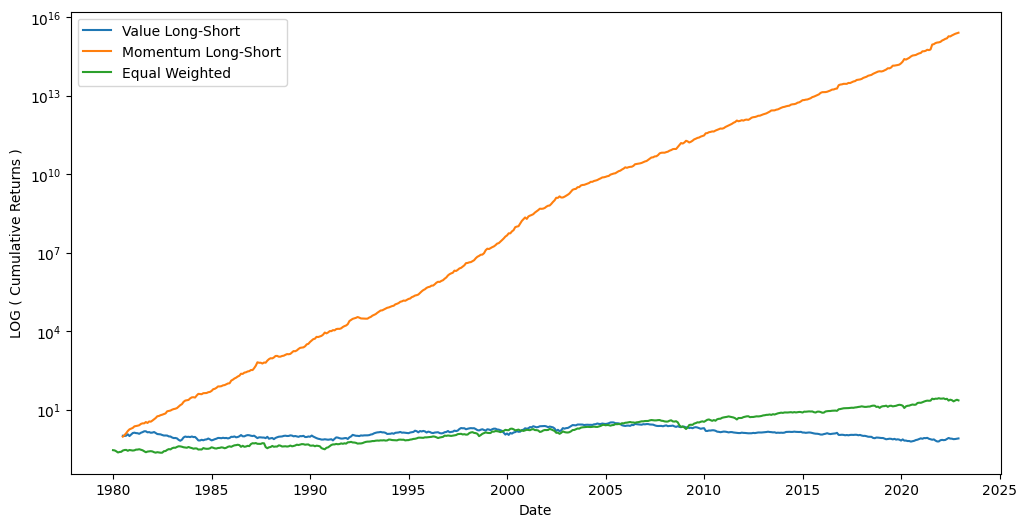

,average_return,volatility,Sharpe_ratio,skewness,kurtosis,max_drawdown
Value_long_short,0.015120,0.203724,0.074219,0.173295,1.148806,-0.815434
MoM_long_short,0.893770,0.241375,3.702825,1.159193,4.626824,-0.139417
Equal_weighted,0.123306,0.203264,0.606629,-0.243811,2.403131,-0.545124


In [169]:
# Calculate equal-weighted returns for each tercile portfolio
bm_tercile_returns = df_tic.groupby(['date', 'bm_tercile'])['monthly_returns'].mean().unstack()
mom_tercile_returns = df_tic.groupby(['date', 'mom_tercile'])['monthly_returns'].mean().unstack()

# Construct long-short portfolios
bm_tercile_returns['Value_long_short'] = bm_tercile_returns['Value_high'] - bm_tercile_returns['Value_low']
mom_tercile_returns['MoM_long_short'] = mom_tercile_returns['MoM_high'] - mom_tercile_returns['MoM_low']

tercile_returns = pd.concat([bm_tercile_returns['Value_long_short'],mom_tercile_returns['MoM_long_short']], axis=1)

# Backtest an equal-weighted portfolio investing in the 50 stocks
equal_weighted_returns = df_tic.groupby('date')['monthly_returns'].mean()
equal_weighted_cumulative = (1 + equal_weighted_returns).cumprod()

# Calculate the cumulative returns for each long-short portfolio
tercile_returns['Value_long_short'] = (1 + tercile_returns['Value_long_short']).cumprod()
tercile_returns['MoM_long_short'] = (1 + tercile_returns['MoM_long_short']).cumprod()

# Calculate annualized performance statistics
annualized_mean_return = df_tic.groupby(['bm_tercile', 'mom_tercile'])['monthly_returns'].mean() * 12
annualized_volatility = df_tic.groupby(['bm_tercile', 'mom_tercile'])['monthly_returns'].std() * np.sqrt(12)

# Plot the cumulative returns
plt.figure(figsize=(12, 6))
plt.plot(tercile_returns.index, tercile_returns['Value_long_short'], label='Value Long-Short')
plt.plot(tercile_returns.index, tercile_returns['MoM_long_short'], label='Momentum Long-Short')
plt.plot(equal_weighted_returns.index, equal_weighted_cumulative, label='Equal Weighted')
plt.xlabel('Date')
plt.ylabel('LOG ( Cumulative Returns )')
plt.yscale('log')
plt.legend()
plt.show()

# Annualized performance statistics
portfolios = {
    'Value_long_short': tercile_returns['Value_long_short'],
    'MoM_long_short': tercile_returns['MoM_long_short'],
    'Equal_weighted': equal_weighted_cumulative
}

stats = pd.DataFrame(index=['average_return', 'volatility', 'Sharpe_ratio', 'skewness', 'kurtosis', 'max_drawdown'], columns=portfolios.keys())

for name, portfolio in portfolios.items():
    returns = portfolio.pct_change().dropna()
    avg_return = returns.mean() * 12
    volatility = returns.std() * np.sqrt(12)
    sharpe_ratio = avg_return / volatility
    skewness_ = skew(returns)
    kurtosis_ = kurtosis(returns)
    drawdowns = (portfolio / portfolio.cummax()) - 1
    max_drawdown = drawdowns.min()
    stats[name] = [avg_return, volatility, sharpe_ratio, skewness_, kurtosis_, max_drawdown]

stats = stats.T
display(stats)



## Data Preparation

We now have book-to-market and stock price information on 50 stocks between 1980 and 2022 in our dataframe. --> A portfolio of 50 stocks

When you look into the lab notebooks of the professor, you see that he works with a dataframe that shows the monthly returns of a set of X portfolios formed on market caps, or market equities of the companies. He then has columns of deciles (Lo 10	Dec 2	Dec 3	Dec 4	Dec 5	Dec 6	Dec 7	Dec 8	Dec 9	Hi 10) of these returns.

We now have to make our dataframe of info about 50 stocks into info about returns & split it into deciles

In [170]:
book_to_market = df_tic['book_to_market']

deciles_btm = book_to_market.groupby('date').quantile([0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1])
df_deciles_btm = deciles_btm.to_frame()
df_deciles_btm = df_deciles_btm.reset_index()
df_deciles_btm = df_deciles_btm.pivot(index='date', columns='level_1', values='book_to_market')
df_deciles_btm = df_deciles_btm.rename_axis(None, axis=1)
df_deciles_btm = df_deciles_btm.rename(columns = {0.1 : 'Lo_10', 0.2 : 'Dec_2', 0.3 : 'Dec_3', 0.4 : 'Dec_4', 0.5 : 'Dec_5', 
                                                  0.6 : 'Dec_6', 0.7 : 'Dec_7', 0.8 : 'Dec_8', 0.9 : 'Dec_9', 1.0 : 'Hi_10', })

display(df_deciles_btm)

#Express returns in %
df_deciles_btm = df_deciles_btm/100
display(df_deciles_btm)


,Lo_10,Dec_2,Dec_3,Dec_4,Dec_5,Dec_6,Dec_7,Dec_8,Dec_9,Hi_10
date,,,,,,,,,,
1980-01-01,0.9770,0.9770,0.9770,0.9770,0.9770,0.9770,0.9770,0.9770,0.9770,0.977
1980-02-01,1.0900,1.0900,1.0900,1.0900,1.0900,1.0900,1.0900,1.0900,1.0900,1.090
1980-03-01,1.0900,1.0900,1.0900,1.0900,1.0900,1.0900,1.0900,1.0900,1.0900,1.090
1980-04-01,1.1362,1.1824,1.2286,1.2748,1.3210,1.3672,1.4134,1.4596,1.5058,1.552
1980-05-01,1.2451,1.2792,1.3133,1.3474,1.3815,1.4156,1.4497,1.4838,1.5179,1.552
...,...,...,...,...,...,...,...,...,...,...
2022-08-01,0.0772,0.1566,0.2170,0.3128,0.3840,0.4530,0.4992,0.6170,0.7691,1.462
2022-09-01,0.0784,0.1566,0.2170,0.3128,0.3840,0.4530,0.4992,0.6170,0.7691,1.462
2022-10-01,0.0791,0.1566,0.2269,0.3128,0.3840,0.4530,0.4992,0.6170,0.7691,1.462


,Lo_10,Dec_2,Dec_3,Dec_4,Dec_5,Dec_6,Dec_7,Dec_8,Dec_9,Hi_10
date,,,,,,,,,,
1980-01-01,0.009770,0.009770,0.009770,0.009770,0.009770,0.009770,0.009770,0.009770,0.009770,0.00977
1980-02-01,0.010900,0.010900,0.010900,0.010900,0.010900,0.010900,0.010900,0.010900,0.010900,0.01090
1980-03-01,0.010900,0.010900,0.010900,0.010900,0.010900,0.010900,0.010900,0.010900,0.010900,0.01090
1980-04-01,0.011362,0.011824,0.012286,0.012748,0.013210,0.013672,0.014134,0.014596,0.015058,0.01552
1980-05-01,0.012451,0.012792,0.013133,0.013474,0.013815,0.014156,0.014497,0.014838,0.015179,0.01552
...,...,...,...,...,...,...,...,...,...,...
2022-08-01,0.000772,0.001566,0.002170,0.003128,0.003840,0.004530,0.004992,0.006170,0.007691,0.01462
2022-09-01,0.000784,0.001566,0.002170,0.003128,0.003840,0.004530,0.004992,0.006170,0.007691,0.01462
2022-10-01,0.000791,0.001566,0.002269,0.003128,0.003840,0.004530,0.004992,0.006170,0.007691,0.01462


## 1. Present annualized performance statistics for your stocks.

This is all code from lab2 to get summary_statistics

(average return, volatility, Sharpe ratio, skewness, kurtosis and max drawdown)


<Axes: xlabel='date'>

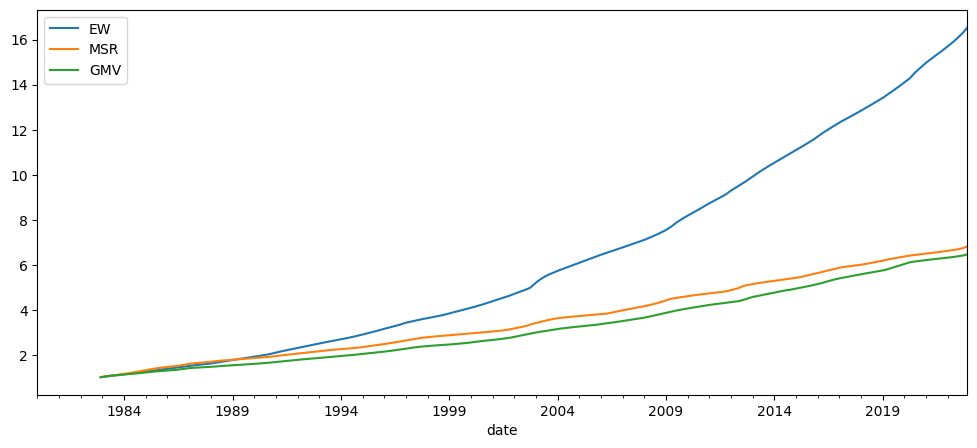

In [171]:
from scipy.optimize import minimize

def backtest_ws(r, weighting, estimation_window=60, **args):
    """
    Backtests a given weighting scheme, given some parameters:
    r : asset returns to use to build the portfolio
    estimation_window: the window to use to estimate parameters
    weighting: the weighting scheme to use, must be a function that takes "r", and a variable number of arguments
    """
    n_periods = r.shape[0]
    # list of overlapping rolling return windows for estimation
    windows = [(start, start+estimation_window) for start in range(n_periods-estimation_window+1)]
    # list of portfolio weights over time
    weights = [weighting(r.iloc[win[0]:win[1]], **args) for win in windows]
    # convert to DataFrame
    weights = pd.DataFrame(weights, index=r.iloc[estimation_window-1:].index, columns=r.columns)
    returns = (weights * r).sum(axis="columns",  min_count=1) #mincount is to generate NAs if all inputs are NAs
    return returns

def weight_ew(r):
    w = [ 1/len(r.columns) for x in range(len(r.columns))]
    w = np.array(w)
    return w

def portfolio_return(weights, returns):
    """
    Computes the return on a portfolio from constituent returns and weights
    weights are a numpy array or Nx1 matrix and returns are a numpy array or Nx1 matrix
    """
    return weights.T @ returns
def portfolio_vol(weights, covmat):
    """
    Computes the vol of a portfolio from a covariance matrix and constituent weights
    weights are a numpy array or N x 1 maxtrix and covmat is an N x N matrix
    """
    return (weights.T @ covmat @ weights)**0.5

def max_sr(riskfree_rate, er, cov):
    """
    Returns the weights of the portfolio that gives you the maximum sharpe ratio
    given the riskfree rate and expected returns and a covariance matrix
    """
    n = er.shape[0]
    init_guess = np.repeat(1/n, n)
    bounds = ((0.0, 1.0),) * n # an N-tuple of 2-tuples!
    # construct the constraints
    weights_sum_to_1 = {'type': 'eq',
                        'fun': lambda weights: np.sum(weights) - 1
    }
    def neg_sharpe(weights, riskfree_rate, er, cov):
        """
        Returns the negative of the sharpe ratio
        of the given portfolio
        """
        r = portfolio_return(weights, er)
        vol = portfolio_vol(weights, cov)
        return -(r - riskfree_rate)/vol
    
    weights = minimize(neg_sharpe, init_guess,
                       args=(riskfree_rate, er, cov), method='SLSQP',
                       options={'disp': False},
                       constraints=(weights_sum_to_1,),
                       bounds=bounds)
    return weights.x

def weight_msr(r):
    er = r.mean()
    cov = r.cov()
    return max_sr(0, er, cov)

def minimize_vol(er, cov):
    """
    Returns the optimal weights that achieve the target return
    given a set of expected returns and a covariance matrix
    """
    n = er.shape[0]
    init_guess = np.repeat(1/n, n)
    bounds = ((0.0, 1.0),) * n # an N-tuple of 2-tuples!
    # construct the constraints
    weights_sum_to_1 = {'type': 'eq',
                        'fun': lambda weights: np.sum(weights) - 1
    }
    weights = minimize(portfolio_vol, init_guess,
                       args=(cov,), method='SLSQP',
                       options={'disp': False},
                       constraints=(weights_sum_to_1,),bounds=bounds)
    return weights.x

def weight_gmv(r):
    er = r.mean()
    cov = r.cov()
    return minimize_vol(er, cov)


# EW: Equal-Weighted, MSR: Maximum Sharpe Ratio, GMV: Global Minimum Volatility
ew_bt = backtest_ws(df_deciles_btm, weighting = weight_ew, estimation_window = 36)
msr_bt = backtest_ws(df_deciles_btm, weighting = weight_msr, estimation_window = 36)
gmv_bt = backtest_ws(df_deciles_btm, weighting = weight_gmv, estimation_window = 36)

btr = pd.DataFrame({"EW": ew_bt, "MSR": msr_bt, "GMV": gmv_bt})
(1+btr).cumprod().plot(figsize=(12,5))


In [172]:
# %load_ext autoreload
# %autoreload 2
import am2023 as am

am.summary_stats(btr.dropna())


,Annualized Return,Annualized Vol,Skewness,Kurtosis,Sharpe Ratio,Max Drawdown
EW,0.072525,0.005981,1.294529,1.294529,6.920323,0.0
MSR,0.049073,0.008318,1.828596,1.828596,2.231818,0.0
GMV,0.047670,0.005471,2.038733,2.038733,3.143345,0.0
